In [52]:
# ----- READING IN THE PROVIDED DATA

import csv
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd 

from   sklearn import linear_model
from   sklearn.metrics import mean_squared_error, r2_score
from   sklearn.model_selection import KFold
from   sklearn.model_selection import cross_val_score
from   sklearn.linear_model import Ridge, Lasso, LassoLarsCV

N_TData = 900;   # data set contains 900 elements

# Train data
ID  = np.zeros(N_TData)
y   = np.zeros(N_TData)
x1  = np.zeros(N_TData)
x2  = np.zeros(N_TData)
x3  = np.zeros(N_TData)
x4  = np.zeros(N_TData)
x5  = np.zeros(N_TData)

# Reading the training data
with open('train.csv') as csvfile:
    reader = csv.DictReader(csvfile, delimiter = ',')
    for row in reader:
        ID[int(row['Id'])] = row['Id']
        y[int(row['Id'])]  = np.float64(row['y'])
        x1[int(row['Id'])] = np.float64(row['x1'])
        x2[int(row['Id'])] = np.float64(row['x2'])
        x3[int(row['Id'])] = np.float64(row['x3'])
        x4[int(row['Id'])] = np.float64(row['x4'])
        x5[int(row['Id'])] = np.float64(row['x5'])

# Transform the data accordingly

# Linear
phy_1  = x1
phy_2  = x2
phy_3  = x3
phy_4  = x4
phy_5  = x5

# Quadratic
phy_6  = np.square(x1)
phy_7  = np.square(x2)
phy_8  = np.square(x3)
phy_9  = np.square(x4)
phy_10 = np.square(x5)

# Exponential
phy_11 = np.exp(x1)
phy_12 = np.exp(x2)
phy_13 = np.exp(x3)
phy_14 = np.exp(x4)
phy_15 = np.exp(x5)

# Cosine
phy_16 = np.cos(x1)
phy_17 = np.cos(x2)
phy_18 = np.cos(x3)
phy_19 = np.cos(x4)
phy_20 = np.cos(x5)

# Constant
phy_21 = np.ones(phy_20.shape)

X_data = (np.vstack((phy_1, phy_2, phy_3, phy_4, phy_5, phy_6, phy_7, phy_8, phy_9, phy_10, phy_11, phy_12, phy_13, phy_14, phy_15, phy_16, phy_17, phy_18, phy_19, phy_20, phy_21))).T

df = pd.DataFrame(X_data)
df.to_csv("xdata.csv", header=None, index=None)

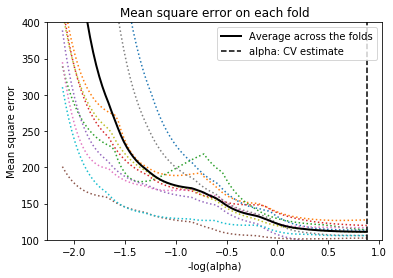

In [53]:
# ----- LASSO REGRESSION

from sklearn.linear_model import LassoCV
lassocv = LassoCV(cv = 10)
lassocv.fit(X_data, y)

m_log_alphas = -np.log10(lassocv.alphas_)

plt.figure()
plt.plot(m_log_alphas, lassocv.mse_path_, ':')
plt.plot(m_log_alphas, lassocv.mse_path_.mean(axis=-1), 'k',label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(lassocv.alpha_), linestyle='--', color='k',label='alpha: CV estimate')
plt.legend()

plt.xlabel('-log(alpha)')
plt.ylabel('Mean square error')
plt.title('Mean square error on each fold')
plt.axis('tight')
plt.ylim(100, 400)

df = pd.DataFrame(lassocv.coef_)
df.to_csv("lassoWeights.csv", header=None, index=None)

Computing regularization path using the Lars lasso...


C:\Users\Jens\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]


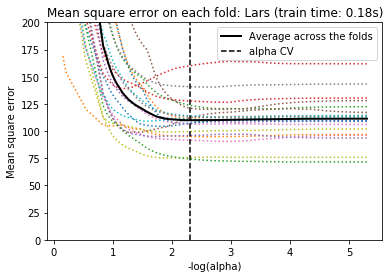

In [63]:
# ----- LASSO LARS REGRESSION
# The object solves the same problem as the LassoCV object. 
# However, unlike the LassoCV, it find the relevant alphas values by itself. 
# In general, because of this property, it will be more stable. 
# However, it is more fragile to heavily multicollinear datasets.

from sklearn.linear_model import LassoLarsCV
import time

print("Computing regularization path using the Lars lasso...")
t1 = time.time()
model = LassoLarsCV(cv=20).fit(X_data, y)

t_lasso_lars_cv = time.time() - t1

# Display results
m_log_alphas = -np.log10(model.cv_alphas_)

plt.figure()
plt.plot(m_log_alphas, model.mse_path_, ':')
plt.plot(m_log_alphas, model.mse_path_.mean(axis=-1), 'k', label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k', label='alpha CV')
plt.legend()

plt.xlabel('-log(alpha)')
plt.ylabel('Mean square error')
plt.title('Mean square error on each fold: Lars (train time: %.2fs)' % t_lasso_lars_cv)
plt.axis('tight')
plt.ylim(0, 200)

plt.show()


import pandas as pd 

df = pd.DataFrame(model.coef_)
df.to_csv("LassoLarsCV_Weights.csv", header=None, index=None)

In [ ]:
################################################################
                    ### OLD APPROACHES ###
################################################################

In [94]:
# ----- DO THE BASIC THING GREGOIRE SUGGESTED
w_basic = np.dot(np.linalg.pinv(np.dot(X_data.T, X_data) + 10*np.identity(21)), np.dot(X_data.T, y))

import pandas as pd 
df = pd.DataFrame(w_basic)
df.to_csv("wbasic.csv", header=None, index=None)

In [122]:
# ----- CROSS VALIDATION, FIND BEST LAMBDA

# 10-Fold creation (randomly because of 'shuffle')
X = X_data

Lambda = np.linspace(0.001,10,100)
Res = np.zeros(100)
kf=KFold(n_splits=10)

for j,i in enumerate(Lambda):
    RMSE = 0
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        w_hat_closed_form = np.dot(np.linalg.pinv(np.dot(X_train.T, X_train)+Lambda[j]*np.identity(21)), np.dot(X_train.T, y_train))        
        y_pred_cf = np.dot(X_test,w_hat_closed_form)        
        RMSE += mean_squared_error(y_test, y_pred_cf)**0.5
    RMSE = RMSE/np.float64(10)
    Res[j]=RMSE
Res

array([10.56892793, 10.56706563, 10.56541115, 10.5639323 , 10.56260097,
       10.56139438, 10.56029429, 10.55928607, 10.5583578 , 10.55749967,
       10.55670353, 10.5559625 , 10.55527076, 10.55462331, 10.55401582,
       10.55344456, 10.55290624, 10.552398  , 10.55191727, 10.55146181,
       10.5510296 , 10.55061885, 10.55022795, 10.54985544, 10.54950002,
       10.54916049, 10.54883579, 10.54852493, 10.54822703, 10.54794126,
       10.54766688, 10.5474032 , 10.54714959, 10.54690548, 10.54667032,
       10.54644362, 10.54622493, 10.54601381, 10.54580988, 10.54561277,
       10.54542213, 10.54523766, 10.54505905, 10.54488603, 10.54471834,
       10.54455573, 10.54439798, 10.54424488, 10.54409622, 10.54395182,
       10.5438115 , 10.5436751 , 10.54354245, 10.54341341, 10.54328784,
       10.54316561, 10.54304658, 10.54293065, 10.54281771, 10.54270763,
       10.54260033, 10.54249571, 10.54239368, 10.54229414, 10.54219703,
       10.54210226, 10.54200975, 10.54191944, 10.54183126, 10.54

10.0

In [67]:
# ----- SPLIT UP THE DATA INTO TRAINING AND VALIDATION DATA (SIMPLE WAY)

# choose random indices from 0 to 899
T_index = random.sample(range(0,N_TData-1), 600)
V_index  = list(map(int,[x for x in np.linspace(0,899,900) if x not in T_index]));

# extract the corresponding data
X_train = X_data[T_index,:]
X_vali  = X_data[V_index,:]

y_train = y[T_index]
y_vali  = y[V_index]

["Test/Validation Datapoints", len(T_index), len(V_index)]

['Test/Validation Datapoints', 600, 300]

In [82]:
# 10-Fold creation

kf=KFold(n_splits=10,shuffle=True)
w_tot = np.zeros(21)

for train_index, test_index in kf.split(X_data):
    X_train, X_test = X_data[train_index], X_data[test_index]
    y_train, y_test = y[train_index], y[test_index]
    w_hat_closed_form = np.dot(np.linalg.pinv(np.dot(X_train.T, X_train)), np.dot(X_train.T, y_train))
    w_tot = w_tot + w_hat_closed_form
    Y_pred_cf = np.dot(X_test,w_hat_closed_form)
    RMSE= mean_squared_error(y_test, Y_pred_cf)**0.5
    print(RMSE)
    
w_res = 1/10*w_tot

w_res

# save data

import pandas as pd 
df = pd.DataFrame(w_res)
df.to_csv("w10f.csv", header=None, index=None)

9.910307617250284
10.245174457714098
11.269241304193839
10.436759767051791
10.628864011301514
9.606820540913057
9.956755336302496
10.304435578816861
10.45776990678672
12.744902804574739


In [69]:
# ----- TRAINING (OLD)

# Create linear regression object
regr = linear_model.LinearRegression()
# Train the model using the training set
regr.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [52]:
# ----- VALIDATION (OLD)

Y_pred = regr.predict(X_vali)

RMSE     = mean_squared_error(y_vali, Y_pred)**0.5
print(RMSE)

11.381153182857222


In [53]:
# ----- EXPORT WEIGHTS

Weights = regr.coef_[:]

import pandas as pd 
df = pd.DataFrame(Weights)
df.to_csv("weights.csv", header=None, index=None)

In [54]:
Weights

array([-3.98908243e+00,  3.85070345e+00, -2.05144941e+00,  6.23106878e+00,
       -3.22272171e+00, -7.66742691e+00,  2.01682732e+00,  3.04142567e-01,
       -1.43369649e+00,  1.30446688e+00,  2.25007339e+00, -4.00958454e+00,
       -6.10755118e-03,  6.50836508e-01, -1.98753957e-01, -1.53763236e+01,
        3.09603978e+00,  1.31421614e+00, -5.62687517e+00,  3.52626443e+00,
        0.00000000e+00])